# Exploratory Analysis
Initial setup and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/raw/sme_d2c_18_months_daily.csv")

Data Checks

In [3]:
df.head()

,date,product,units_sold,unit_price,cogs_per_unit,fulfilment_cost_per_unit,marketing_spend,returns_rate
0,2023-01-01,Product A,85,25,13,3,341.70,0.052
1,2023-01-01,Product B,53,40,23,4,327.13,0.046
2,2023-01-01,Product C,25,60,32,5,203.51,0.027
3,2023-01-01,Product D,19,90,48,7,209.79,0.017
4,2023-01-02,Product A,90,25,13,3,276.75,0.089


In [4]:
df.shape

(2188, 8)

In [5]:
df.columns

Index(['date', 'product', 'units_sold', 'unit_price', 'cogs_per_unit',
       'fulfilment_cost_per_unit', 'marketing_spend', 'returns_rate'],
      dtype='object')

In [6]:
df.isna().sum()

date                        0
product                     0
units_sold                  0
unit_price                  0
cogs_per_unit               0
fulfilment_cost_per_unit    0
marketing_spend             0
returns_rate                0
dtype: int64

No missing values in any column.

In [7]:
df.dtypes

date                         object
product                      object
units_sold                    int64
unit_price                    int64
cogs_per_unit                 int64
fulfilment_cost_per_unit      int64
marketing_spend             float64
returns_rate                float64
dtype: object

Core financial metrics

In [8]:
df["date"] = pd.to_datetime(df["date"])

In [9]:
df["revenue"] = df["units_sold"] * df["unit_price"]
df["cogs"] = df["units_sold"] * df["cogs_per_unit"]
df["returns_cost"] = df["revenue"] * df["returns_rate"]
df["fulfilment_cost"] = df["units_sold"] * df["fulfilment_cost_per_unit"]
df["gross_profit"] = df["revenue"] - df["cogs"]
df["net_profit"] = (
    df["gross_profit"] 
    - df["fulfilment_cost"] 
    - df["returns_cost"] 
    - df["marketing_spend"]
)

In [10]:
product_summary = (
    df.groupby("product")
    .agg(
        total_revenue = ("revenue","sum"),
        total_profit = ("net_profit", "sum"),
        total_volume = ("units_sold", "sum")
    )
    .sort_values("total_revenue", ascending=False)
)

product_summary

,total_revenue,total_profit,total_volume
product,,,
Product B,1752840,326067.090,43821
Product A,1575775,268857.665,63031
Product C,1413720,363556.120,23562
Product D,1409400,403001.050,15660


Here we do a performance analysis using revenue and profit metrics derived at the daily product level.

The summary shows how different revenue is, with each product varying in price and volume. Products with high sales volume do not necessarily generate the greatest profit. Signs suggest each product has a different margin structure.

In [11]:
df["month"] = df["date"].dt.to_period("M")

In [12]:
monthly_performance = (
    df.groupby(["month", "product"])
      .agg(
          monthly_revenue=("revenue", "sum"),
          monthly_net_profit=("net_profit", "sum"),
      )
      .reset_index()
)

In [13]:
monthly_revenue_pivot = monthly_performance.pivot(
    index = "month",
    columns = "product",
    values = "monthly_revenue"
)

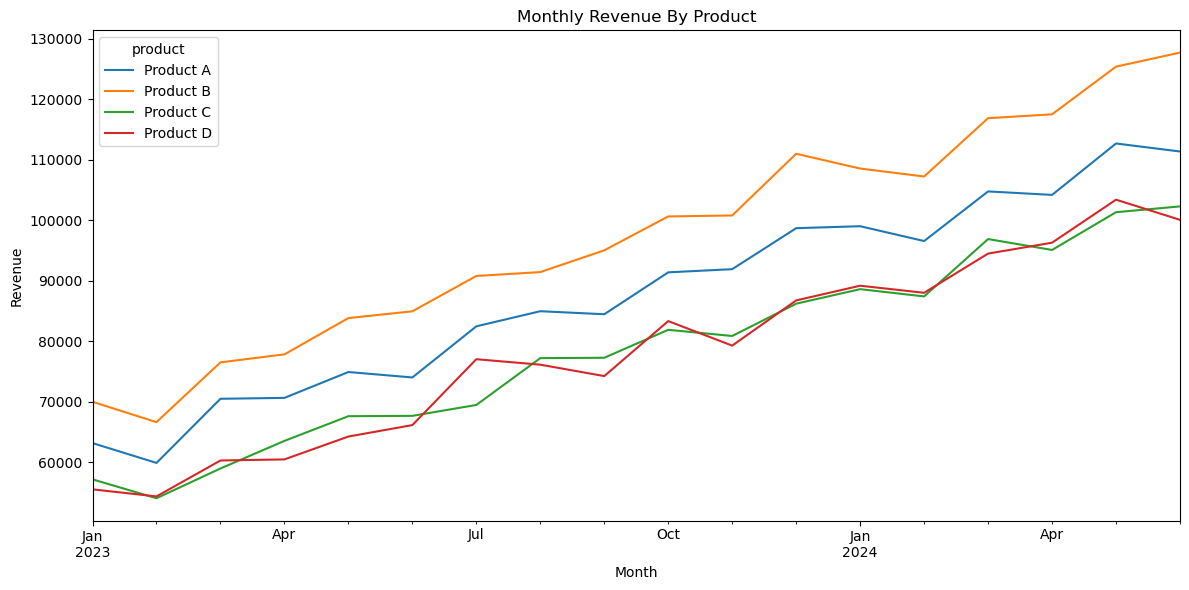

In [14]:
monthly_revenue_pivot.plot(figsize=(12,6))
plt.title("Monthly Revenue By Product")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()

In [15]:
monthly_net_profit_pivot = monthly_performance.pivot(
    index = "month",
    columns = "product",
    values = "monthly_net_profit"
)

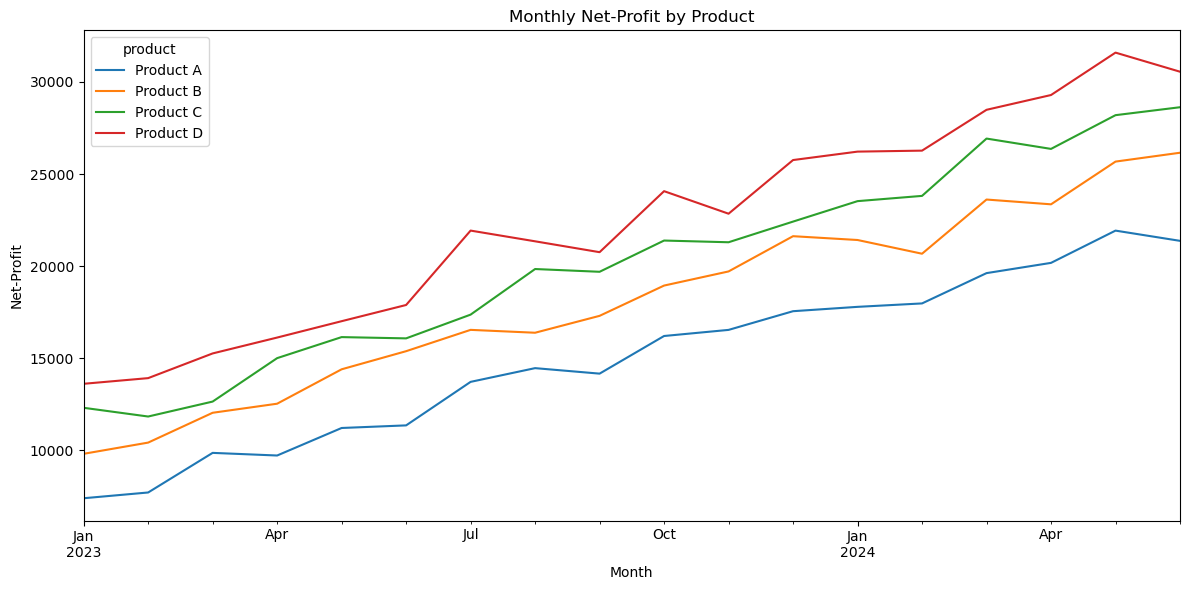

In [16]:
monthly_net_profit_pivot.plot(figsize=(12,6))
plt.title("Monthly Net-Profit by Product")
plt.xlabel("Month")
plt.ylabel("Net-Profit")
plt.tight_layout()
plt.show()

Revenue is on an upwards trend, suggesting growing demand for products.
Profitability differs by product, with some products showing growth in monthly net-profits even with a drop in revenue; this indicates instability in some products operational/fulfilment costs.

This exploratory analysis highlights clear differences in how profitability differs across each product. While growth is evident, we need to analyse which products rely on high volumes to generate revenue, and which have healthy margins that can be scaled. Next we will break down each product to understand it's unit economics and scaleability.

In [17]:
df.to_csv("../data/processed/sme_d2c_processed.csv", index=False)